In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from haversine import haversine
CSV_DATA = Path().cwd().parent.parent / "data/0_extracted/processed/"

In [2]:
def read_ride_csv(file_path:str, time_columns:list[str]=None):
    if time_columns is None: time_columns=['time']
    # Read in the CSV file for the Ride
    df = pd.read_csv(file_path)
    
    # guarantee the timestamps are datetime objects
    for time_col in time_columns:
        df[time_col] = pd.to_datetime(df[time_col])

    return df

In [3]:
jan_ride_path = CSV_DATA / "January_no_sensor.csv"
apr_ride_path = CSV_DATA / "April_one_sensor.csv"
may_ride_path = CSV_DATA / "May_two_sensor.csv"
df_jan = read_ride_csv(jan_ride_path)
df_apr = read_ride_csv(apr_ride_path)
df_may = read_ride_csv(may_ride_path)

In [4]:
drop_columns = ['ride_id', 'track_id']
df_jan = df_jan.drop(columns=drop_columns)
df_apr = df_apr.drop(columns=drop_columns)
df_may = df_may.drop(columns=drop_columns)
add_null_columns = ['atemp', 'hr'] # if these columns don't already exist add them as np.null

for df in [df_jan, df_apr, df_may]:
    for col in add_null_columns:
        if col not in df.columns:
            df[col] = np.nan

# 1. Enrich & Upsample Time

In [5]:
class TimeUpsampler:
    def process(self, df:pd.DataFrame, time_gap_threshold:int=15) -> pd.DataFrame:
        df = df.copy()
        df = self.enrich_time_data(df)
        df['elapsed_time'] = df['delta_time'].cumsum()
        df = self.label_continuous_segments(df, time_gap_threshold)
        df_upsampled = self.normalize_sampling_rate(df)
        return df_upsampled

    @staticmethod
    def enrich_time_data(df:pd.DataFrame, time_column:str='time', fill_first:float=1.0):
        df = df.copy()
        # Temporarily get the number of seconds since Jan. 1, 1970 as the UTC timestamp
        df['time_utc'] = df[time_column].apply(lambda x: x.timestamp())
        
        # Calculate the row-wise difference in time (in seconds)
        df['delta_time'] = df['time_utc'].diff()
        
        # drop the temporary time column
        df.drop(['time_utc'], axis=1, inplace=True)
        
        # fill in the initial value of delta_time with @fill_first
        df['delta_time'] = df['delta_time'].fillna(fill_first)
        
        return df
    
    @staticmethod
    def label_continuous_segments(df: pd.DataFrame, time_gap_threshold:int=15):
        df = df.copy()
        # get the time gap indices
        # Calculate when the time discontinuities occur
        filt_time_jump = df['delta_time'] >= time_gap_threshold
        time_gap_indices = list(df.loc[filt_time_jump, 'time'].index)

        # intialize the initial segment_id. to be incremented for each region of continuous data
        segment_id_counter = 0
        # initialize the starting index of the first segment
        segment_start_index = 0

        for time_gap_index in time_gap_indices:
            # Assign the Segment ID
            df.loc[segment_start_index:time_gap_index-1, 'segment_id'] = segment_id_counter
            
            # update the segment_id counter and start index
            segment_id_counter += 1
            segment_start_index = time_gap_index
            
        # Since segment_id == -1 by default, this represents the final segment of activity once parsed
        df['segment_id'] = df['segment_id'].replace({-1:segment_id_counter})

        # Since the delta_time column is no longer needed to detect discontinuities,
        # Drop delta_time so we can rebuild it at a segment_id level
        df.drop(['delta_time'], axis=1, inplace=True)
        return df
    
    @staticmethod
    def upsample_and_interpolate(df: pd.DataFrame, time_column:str='time', method:str='linear', limit_direction:str='forward'):
        # set the timestamp as the index for the dataframe
        df = df.set_index(time_column).copy()
        df = df.resample('s').interpolate(method=method, limit_direction=limit_direction).reset_index()
        return df
    
    def normalize_sampling_rate(self, df: pd.DataFrame, partition_column:str='segment_id') -> pd.DataFrame:
        df = df.copy()
        functions_to_apply = [self.upsample_and_interpolate, self.enrich_time_data]
        for func in functions_to_apply:
            df = pd.concat(list(map(func, [df_group for _,df_group in df.groupby(partition_column)])), ignore_index=True).sort_index()
        return df

In [6]:
upsampler = TimeUpsampler()
df_jan = upsampler.process(df_jan)
df_apr = upsampler.process(df_apr)
df_may = upsampler.process(df_may)

In [7]:
from functools import reduce

class BasicEnricher:
    def process(self, df:pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        process_steps = [self.compute_distance, self.compute_heading, self.compute_speed, self.flag_cruising_rows, 
                         self.convert_elevation, self.compute_grade, self.compute_cumulative_elevation_changes]
        
        df_enriched = reduce(lambda df,func:func(df), process_steps, df)
        return df_enriched

    ##############################################################################################
    # Distance and Heading from Lat/Long
    ##############################################################################################
    @staticmethod
    def compute_distance(df, latitude='latitude', longitude='longitude', fill_first=np.nan):
        df = df.copy()
        # Copy the previous values of Lat/Long to the current row for vectorized computation
        df['lat_old'] = df[latitude].shift()
        df['long_old'] = df[longitude].shift()
        
        # Grab the relevant columns for distance calculation
        df_gps = df[['lat_old', 'long_old', latitude, longitude]]
        
        # Define an anonymous function to execute over each row to calculate the distance between rows
        haversine_distance = lambda x: haversine((x.iloc[0], x.iloc[1]), (x.iloc[2], x.iloc[3]), unit='mi')
        
        # Create the distance column, making sure to apply the function row-by-row
        df['delta_dist'] = df_gps.apply(haversine_distance, axis=1)
        df['delta_dist'] = df['delta_dist'].fillna(fill_first)
        
        # Remove the old latitude and longitude columns
        df.drop(['lat_old','long_old'], axis=1, inplace=True)
        return df

    @staticmethod
    def compute_heading(df, latitude='latitude', longitude='longitude'):
        df = df.copy()
        # Copy the previous values of Lat/Long to the current row for vectorized computation
        df['lat_old'] = df[latitude].shift()
        df['long_old'] = df[longitude].shift()
        
        # Grab the relevant columns for distance calculation
        df_gps = df[['lat_old', 'long_old', latitude, longitude]]
        
        # Define an anonymous function to execute over each row to calculate the angle with North as 0 degrees
        # NOTE: we use "delta_lat / delta_long" to ensure that North = 0 degrees
        rad2deg = 180.0 / np.pi
        heading = lambda x: rad2deg * np.arctan2((x.iloc[2]-x.iloc[0]), (x.iloc[3]-x.iloc[1])) # atan(delta_lat / delta_long)
        
        # Create the distance column, making sure to apply the function row-by-row
        df['heading'] = df_gps.apply(heading, axis=1)
        df['heading'] = df['heading'].apply(lambda x: x + 360.0*(1-np.sign(x))/2) # correct for negative angles
        
        # Remove the old latitude and longitude columns
        df.drop(['lat_old','long_old'], axis=1, inplace=True)
        return df

    ##############################################################################################
    # Speed Enrichments
    ##############################################################################################
    @staticmethod
    def compute_speed(df):
        df = df.copy()
        miles_per_second_2_MPH = 3600.0 / 1.0 # conversion factor
        df['speed'] = miles_per_second_2_MPH * df['delta_dist'] / df['delta_time']
        return df

    @staticmethod
    def flag_cruising_rows(df, start_threshold_mph:float=8.0, stop_threshold_mph:float=5.0):
        """
        Scmitt Trigger to implement a hysteresis state machine for determining a state
        """
        df = df.copy()
        df['is_cruising'] = False

        for k in range(1, df.shape[0]):
            previous_state = df.loc[k-1,'is_cruising']
            current_speed = df.loc[k,'speed']
            if (previous_state==False) & (current_speed >= start_threshold_mph):
                df.loc[k,'is_cruising'] = True # rising threshold surpassed
            elif (previous_state==True) & (current_speed < stop_threshold_mph):
                df.loc[k,'is_cruising'] = False # rising threshold surpassed
            else:
                # if there is no change, propogate the previous state
                df.loc[k,'is_cruising'] = df.loc[k-1,'is_cruising']
        return df

    ##############################################################################################
    # Elevation Enrichments
    ##############################################################################################
    @staticmethod
    def convert_elevation(df):
        df = df.copy()
        meters_to_feet = 3.281
        df['elevation'] = df['elevation'] * meters_to_feet
        return df

    @staticmethod
    def compute_grade(df, fill_first=0.0):
        df = df.copy()
        # create an elevation difference
        feet_to_miles = 1.0 / 5280.0
        df['delta_ele'] = df['elevation'].diff() * feet_to_miles
        df['delta_ele'] = df['delta_ele'].fillna(fill_first)
        
        # create the grade column as a percent
        df['grade'] = 100.0 * (df['delta_ele'] / df['delta_dist'])
        
        # drop the elevation difference
        df.drop(['delta_ele'], axis=1, inplace=True)
        
        return df

    @staticmethod
    def compute_cumulative_elevation_changes(df, fill_first=0.0):
        df = df.copy()
        
        # create an elevation difference
        df['delta_ele'] = df['elevation'].diff()
        df['delta_ele'] = df['delta_ele'].fillna(fill_first)
        
        # create delta ascent and delta descent columns
        df['delta_ascent'] = df.loc[df['delta_ele']>=0, 'delta_ele']
        df['delta_descent'] = df.loc[df['delta_ele']<=0, 'delta_ele']
        
        # create the cumulative versions
        df['elapsed_ascent'] = df['delta_ascent'].cumsum()
        df['elapsed_ascent'] = df['elapsed_ascent'].interpolate() # fill in any blanks
        df['elapsed_descent'] = df['delta_descent'].cumsum()
        df['elapsed_descent'] = np.abs(df['elapsed_descent'].interpolate()) # fill in any blanks
        
        # create the total elevation change column
        df['elapsed_elevation'] = df['elapsed_ascent'] + df['elapsed_descent']
            
        # drop the elevation differences
        df.drop(['delta_ele','delta_ascent','delta_descent'], axis=1, inplace=True)
        
        return df

In [8]:
enricher = BasicEnricher()
df_jan = enricher.process(df_jan)
df_apr = enricher.process(df_apr)
df_may = enricher.process(df_may)

In [11]:
df_apr.head()

,time,segment_id,elevation,latitude,longitude,atemp,hr,elapsed_time,delta_time,delta_dist,heading,speed,is_cruising,grade,elapsed_ascent,elapsed_descent,elapsed_elevation
0,2025-04-12 17:21:13+00:00,0.0,483.6194,39.139397,-84.341631,29.0,93.00,1.0,1.0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0
1,2025-04-12 17:21:14+00:00,0.0,483.6194,39.139397,-84.341631,29.0,91.00,2.0,1.0,0.0,180.0,0.0,False,NaN,0.0,0.0,0.0
2,2025-04-12 17:21:15+00:00,0.0,483.6194,39.139397,-84.341631,29.0,94.00,3.0,1.0,0.0,180.0,0.0,False,NaN,0.0,0.0,0.0
3,2025-04-12 17:21:16+00:00,0.0,483.6194,39.139397,-84.341631,29.0,90.00,4.0,1.0,0.0,180.0,0.0,False,NaN,0.0,0.0,0.0
4,2025-04-12 17:21:17+00:00,0.0,483.6194,39.139397,-84.341631,29.0,89.25,5.0,1.0,0.0,180.0,0.0,False,NaN,0.0,0.0,0.0


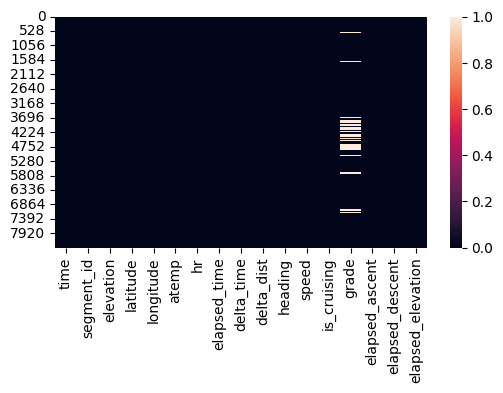

In [ ]:
# Check for nulls after the transformations
_ = plt.figure(figsize=(6,3))
_ = sn.heatmap(df_jan.isna())

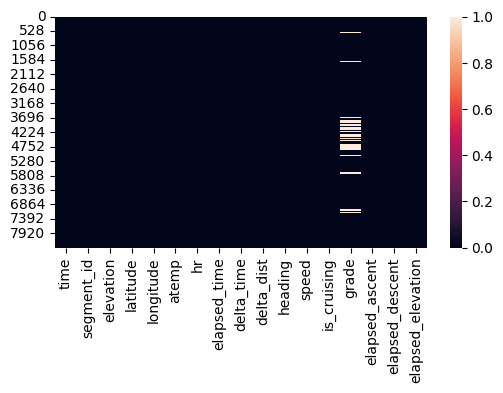

In [18]:
# Check for nulls after the transformations
_ = plt.figure(figsize=(6,3))
_ = sn.heatmap(df_apr.isna())

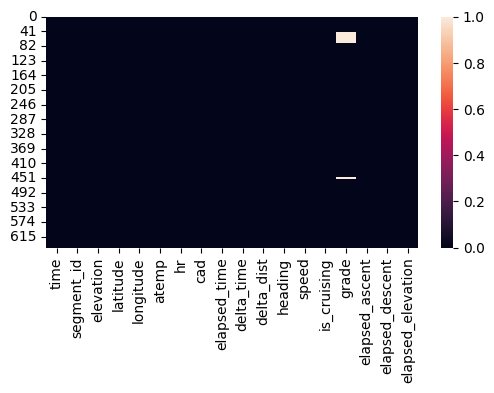

In [16]:
# Check for nulls after the transformations
_ = plt.figure(figsize=(6,3))
_ = sn.heatmap(df_may.isna())

# Inspect the Enriched Columns

In [24]:
def plot_state_column(df:pd.DataFrame, column:str, color_by:str='segment_id',figsize=(15,3),
                       ylims:list[float]=None, units:str='none') -> None:
    _ = plt.figure(figsize=figsize)
    _ = sn.lineplot(df, x='elapsed_time', y=column, hue=color_by, palette='hls', legend=False)
    _ = plt.grid()
    _ = plt.title(f'{column.upper()} Segments', fontsize=18)
    _ = plt.xlabel('Elapsed Time (seconds)', fontsize=14)
    _ = plt.ylabel(f'{column.upper()} ({units})', fontsize=14)
    if ylims is not None:
        _ = plt.ylim(ylims)

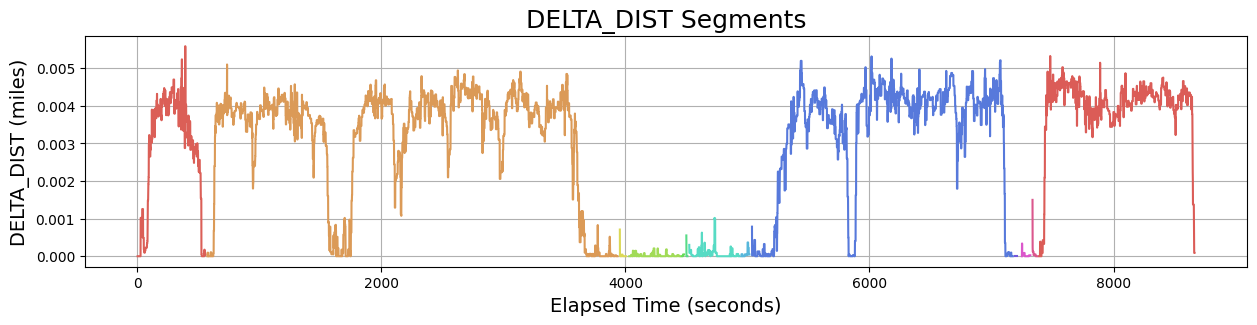

In [26]:
plot_state_column(df_apr,'delta_dist', units='miles')

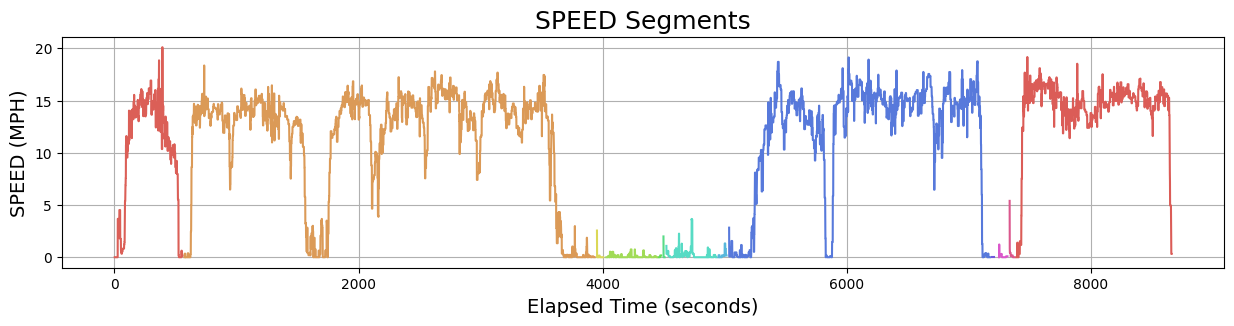

In [27]:
plot_state_column(df_apr,'speed', units='MPH')

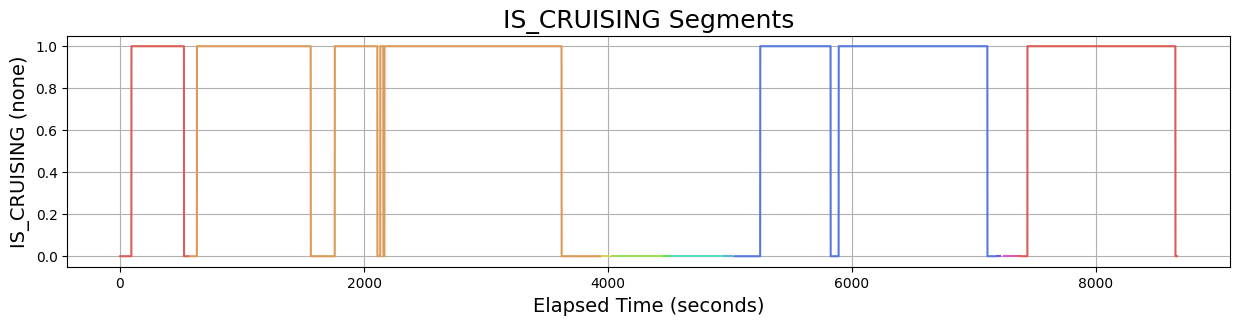

In [30]:
plot_state_column(df_apr,'is_cruising', units='none')

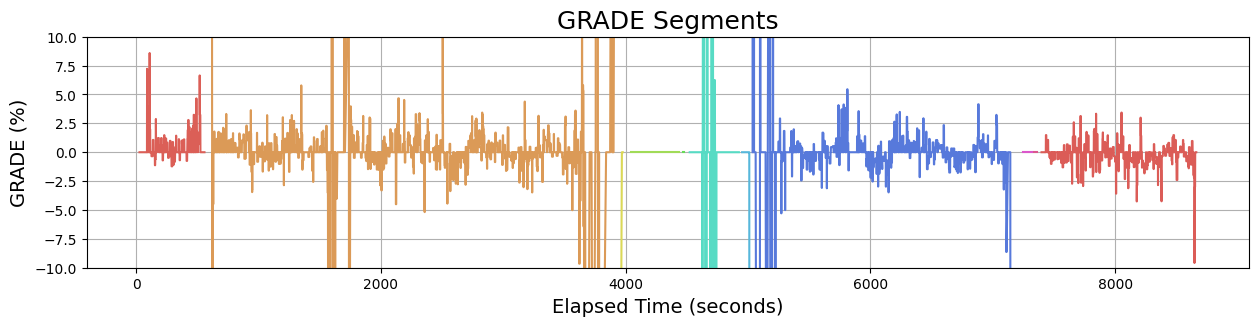

In [31]:
plot_state_column(df_apr,'grade', units='%', ylims=[-10,10])

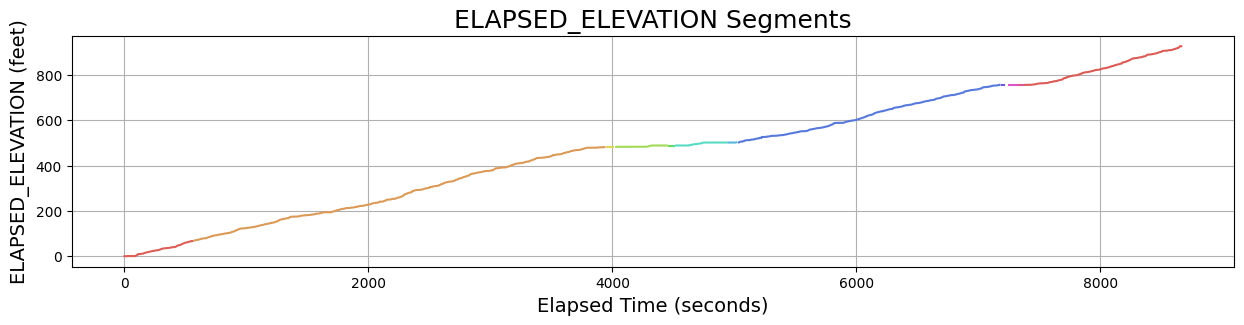

In [32]:
plot_state_column(df_apr,'elapsed_elevation', units='feet')

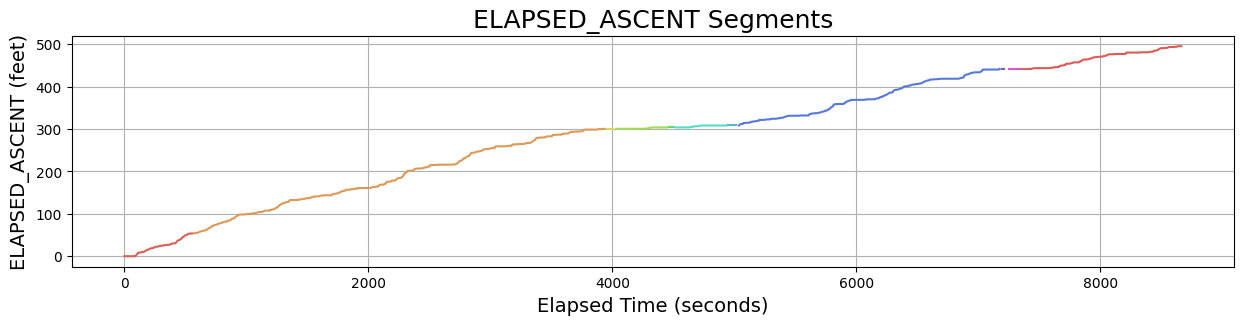

In [33]:
plot_state_column(df_apr,'elapsed_ascent', units='feet')

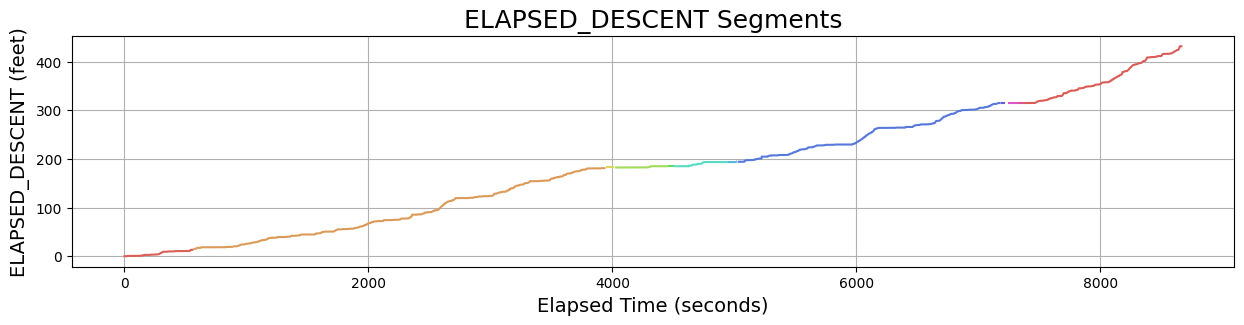

In [34]:
plot_state_column(df_apr,'elapsed_descent', units='feet')